# Evaluate if the pangenome pipeline produces similar count profiles as a "gold standard" pipeline when the sample is a strain for which we have a reference genome

This notebook examines whether the pangenome pipeline produces counts that correlate with a "gold standard" pipeline. 

The **pangenome pipeline** determines which species the majority of reads come from, generates a reference sequence by downloading all reference genomes for that species, extracts coding and RNA sequences for all genomes, clusters sequences at 95% identity, and mapping (quant) against these sequences using salmon. Intergenic sequences are given to salmon as decoy sequences so that any read that maps better to intergenic sequences (e.g. as may be transcribed in polycistronic transcripts) will not be counted, but will be labelled as mapping to intergenic. 

The **gold standard pipeline** uses STAR to map reads against the best-matching reference genome when the RNA-seq sample is compared against all genomes in the GTDB genome database. 

In this notebook, we present results for three RNA seq samples from the strain *Faecalibacterium prausnitzii* A2-165 strain=JCM 31915, ASM1050957v1 (represented by *Faecalibacterium prausnitzii_C* in the GTDB database). *F. prausnitzii* A2-165 was the only match found between each RNA seq sample and the genomes in the GTDB database, giving strong support that these samples are single-isolate samples, and that the strain present is the same as the strain found in the reference database. As such, this notebook tests whether pangenome construction captures the same count information as using the reference genome alone. 

In [21]:
library(dplyr)
library(readr)
library(tidyr)
library(purrr)
library(ggplot2)
library(modelr)
library(broom)
source("scripts/utils.R")

In [3]:
# change working dir to one level above notebooks dir
setwd("..") 

In [4]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200) 

### make annotation map between pangenome and reference seq

In [6]:
fpc_annot_map <- read_cdhit_clstr("outputs/gtdb_genomes_annotated_comb/s__Faecalibacterium_prausnitzii_C_clustered_annotated_seqs.fa.clstr")

## Single end data

### import and format counts

In [11]:
gs_se_ref_counts <- Sys.glob("outputs/gs_rnaseq_featurecounts/*counts.txt") %>%
  set_names() %>%
  map_dfr(read_delim, delim = " ", skip = 1, show_col_types = FALSE,
          col_names =  c("sequence_name", "chr", "start", "end", "strand", "length", 
                         "gs_se_ref_counts"), .id = "sample") %>%
  mutate(sample = gsub("outputs/gs_rnaseq_featurecounts/GCF_010509575.1-", "", sample)) %>%
  mutate(sample = gsub("_counts.txt", "", sample)) %>%
  select(sequence_name, gs_se_ref_counts, sample)  

salmon <- Sys.glob("outputs/rnaseq_salmon/s__Faecalibacterium_prausnitzii_C/*_quant/quant.sf") %>%
  set_names() %>%
  map_dfr(read_tsv, show_col_types = FALSE, .id = "sample") %>%
  mutate(sample = gsub("outputs/rnaseq_salmon/s__Faecalibacterium_prausnitzii_C/", "", sample)) %>%
  mutate(sample = gsub("_quant/quant.sf", "", sample)) %>%
  select(Name, salmon_counts = NumReads, sample) %>%
  left_join(fpc_annot_map, by = c("Name" = "representative")) %>%
  filter(sequence_name %in% gs_se_ref_counts$sequence_name) %>%
  select(sequence_name, salmon_counts, sample)


counts <- full_join(gs_se_ref_counts, salmon, by = c("sequence_name", "sample")) %>%
  mutate(log10_salmon_counts = log10(salmon_counts),
         log10_salmon_counts = ifelse(!is.finite(log10_salmon_counts), 0, log10_salmon_counts),
         log10_gs_se_ref_counts = log10(gs_se_ref_counts), 
         log10_gs_se_ref_counts = ifelse(!is.finite(log10_gs_se_ref_counts), 0, log10_gs_se_ref_counts))

### plot

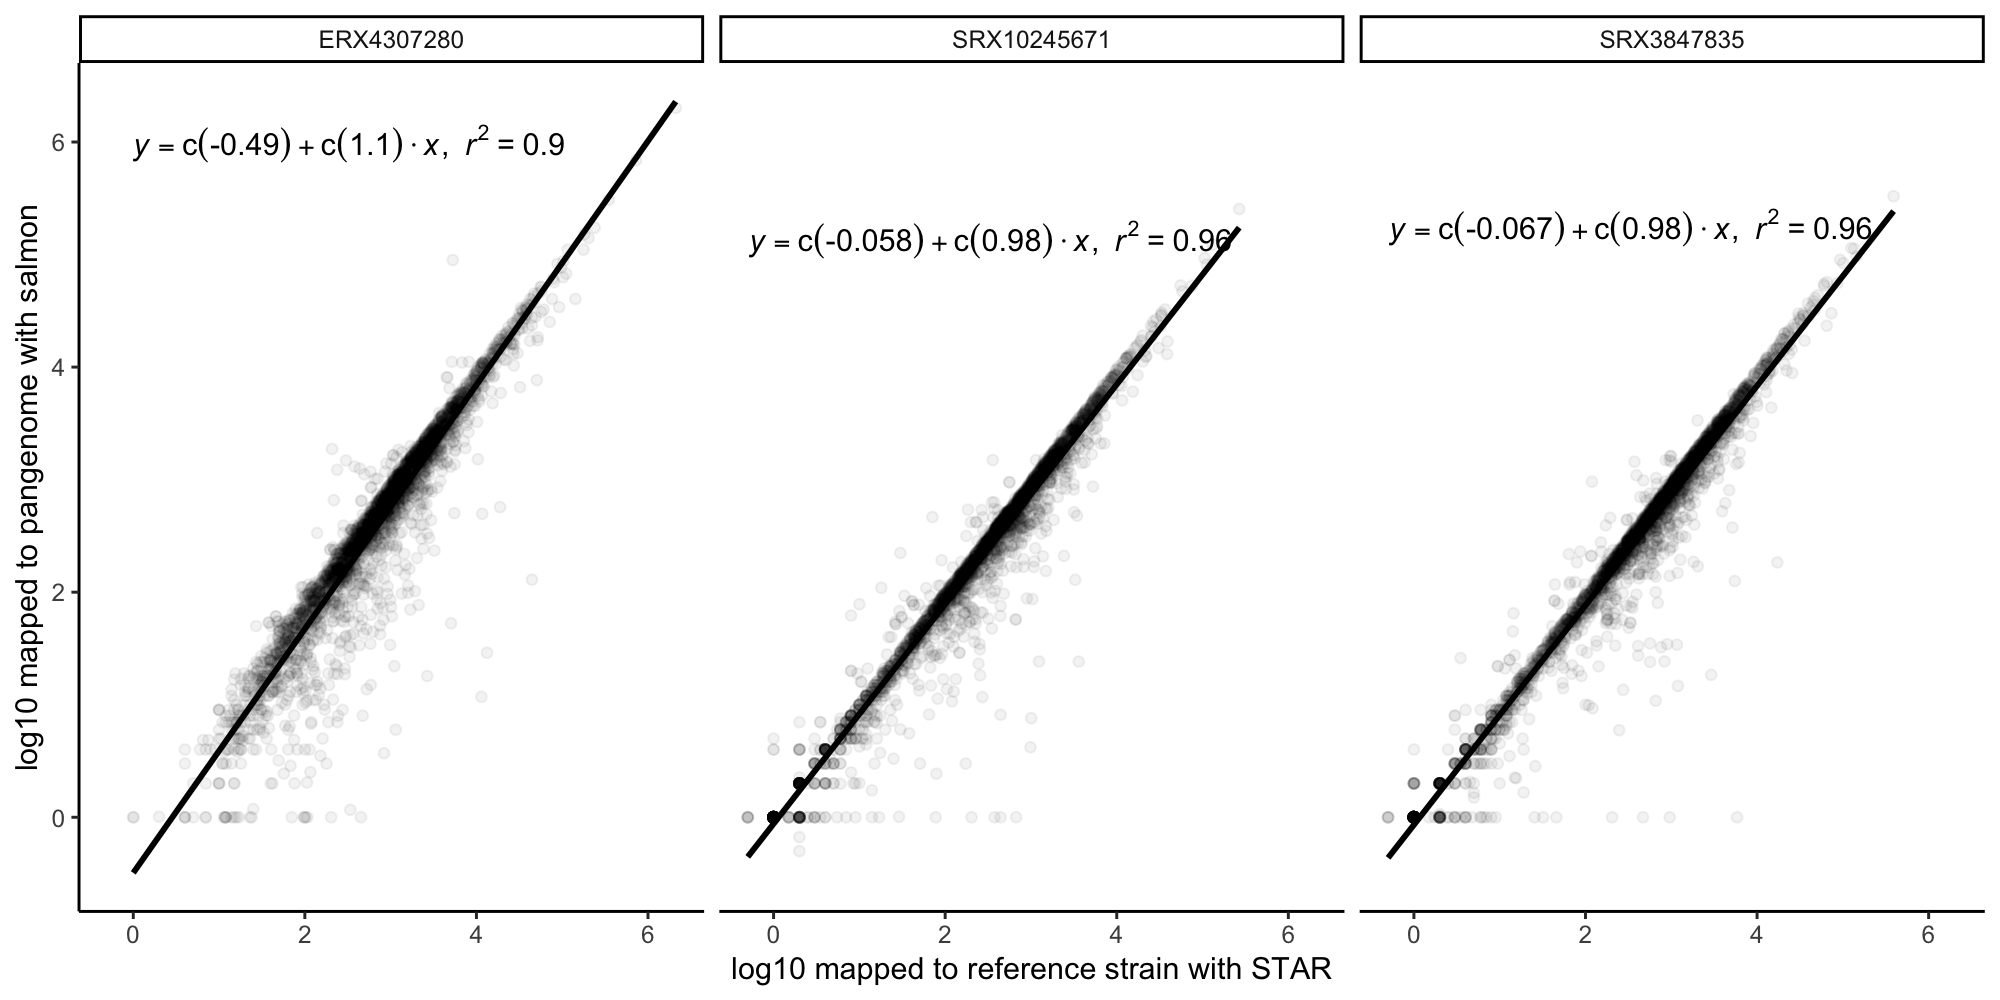

In [22]:
ggplot(counts, aes(x = log10_gs_se_ref_counts, y = log10_salmon_counts, label = sequence_name))  +
  geom_point(alpha = .05) +
  theme_classic() +
  labs(x = "log10 mapped to reference strain with STAR",
       y = "log10 mapped to pangenome with salmon") +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  facet_wrap(~sample)

### calculate residuals to determine if outliers are shared across RNA-seq libraries

In [23]:
models <- counts %>% 
  group_by(sample) %>% 
  nest() %>%
  mutate(model = map(data, ~lm(log10_salmon_counts ~ log10_gs_se_ref_counts, data = .)),
         residuals = map2(data, model, add_residuals))

residuals <- models %>% 
  unnest(residuals) %>% 
  select(sample, sequence_name, gs_se_ref_counts, salmon_counts, 
         log10_salmon_counts, log10_gs_se_ref_counts, resid) %>%
  arrange(desc(resid))

In [24]:
residuals

sample,sequence_name,gs_se_ref_counts,salmon_counts,log10_salmon_counts,log10_gs_se_ref_counts,resid
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ERX4307280,GCF_010509575.1_14055,5300.40,89316.000,4.950929,3.724309,1.4082438
ERX4307280,GCF_010509575.1_10420,207.50,1875.000,3.273001,2.317018,1.2556073
SRX3847835,GCF_010509575.1_09900,119.00,958.996,2.981817,2.075547,1.0245620
ERX4307280,GCF_010509575.1_10995,238.00,1224.000,3.087781,2.376577,1.0058346
ERX4307280,GCF_010509575.1_06130,302.00,1479.000,3.169968,2.480007,0.9759188
SRX10245671,GCF_010509575.1_10230,10.00,78.079,1.892534,1.000000,0.9742856
SRX10245671,GCF_010509575.1_05750,8.00,62.000,1.792392,0.903090,0.9687289
SRX10245671,GCF_010509575.1_10995,30.00,223.217,2.348727,1.477121,0.9647998
SRX3847835,GCF_010509575.1_10230,3.50,25.999,1.414957,0.544068,0.9512245


## Paired end data

In [25]:
gs_pe_ref_counts <- Sys.glob("outputs/gs_rnaseq_featurecounts_pe/*counts.txt") %>%
  set_names() %>%
  map_dfr(read_delim, delim = " ", skip = 1, show_col_types = FALSE,
          col_names =  c("sequence_name", "chr", "start", "end", "strand", "length", 
                         "gs_pe_ref_counts"), .id = "sample") %>%
  mutate(sample = gsub("outputs/gs_rnaseq_featurecounts_pe/GCF_010509575.1-", "", sample)) %>%
  mutate(sample = gsub("_counts.txt", "", sample)) %>%
  select(sequence_name, gs_pe_ref_counts, sample)  

In [26]:
head(gs_pe_ref_counts)

sequence_name,gs_pe_ref_counts,sample
<chr>,<dbl>,<chr>
GCF_010509575.1_00005,1085.0,SRX10245671
GCF_010509575.1_00010,944.5,SRX10245671
GCF_010509575.1_00015,103.5,SRX10245671
GCF_010509575.1_00020,327.0,SRX10245671
GCF_010509575.1_00025,68.5,SRX10245671
GCF_010509575.1_00030,1166.5,SRX10245671


In [27]:
counts2 <- full_join(gs_pe_ref_counts, counts, by = c("sequence_name", "sample")) %>%
  mutate(log10_gs_pe_ref_counts = log10(gs_pe_ref_counts), 
         log10_gs_pe_ref_counts = ifelse(!is.finite(log10_gs_pe_ref_counts), 0, log10_gs_pe_ref_counts))

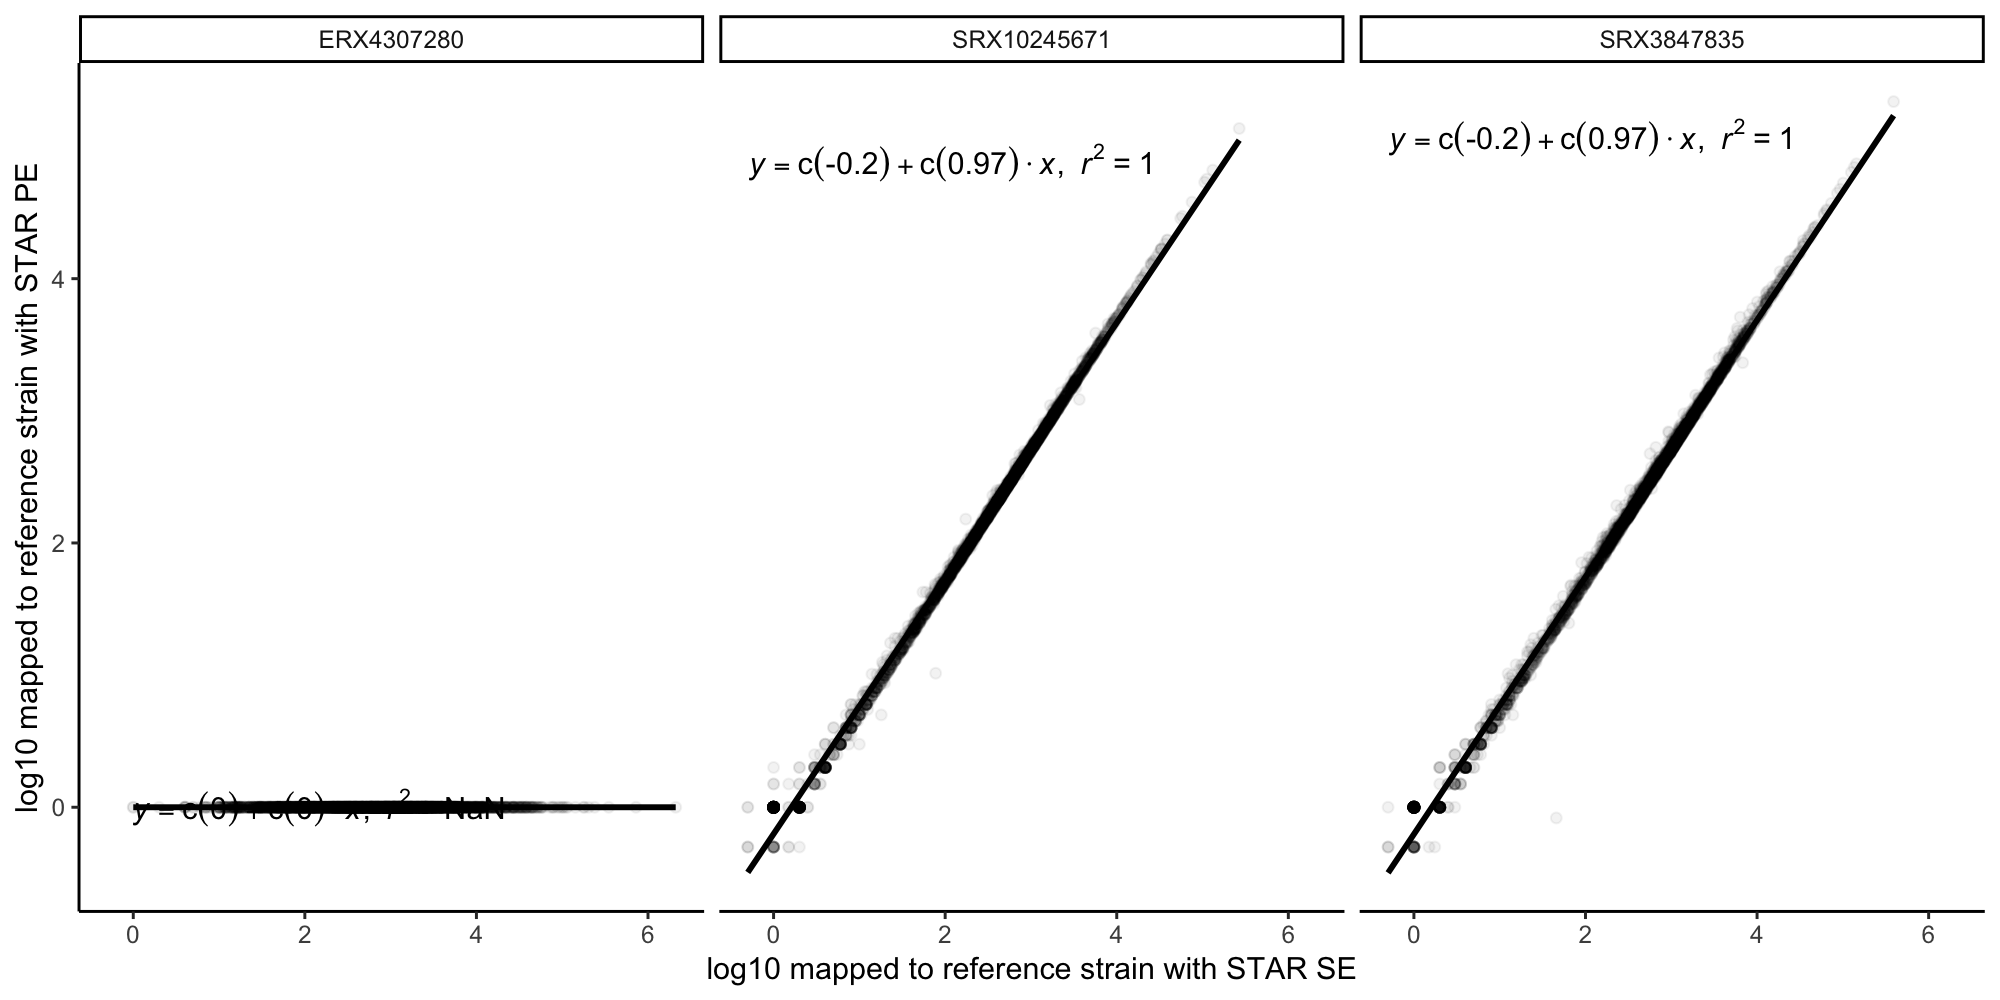

In [28]:
ggplot(counts2, aes(x = log10_gs_se_ref_counts, y = log10_gs_pe_ref_counts, label = sequence_name))  +
  geom_point(alpha = .05) +
  theme_classic() +
  labs(x = "log10 mapped to reference strain with STAR SE",
       y = "log10 mapped to reference strain with STAR PE") +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  facet_wrap(~sample)

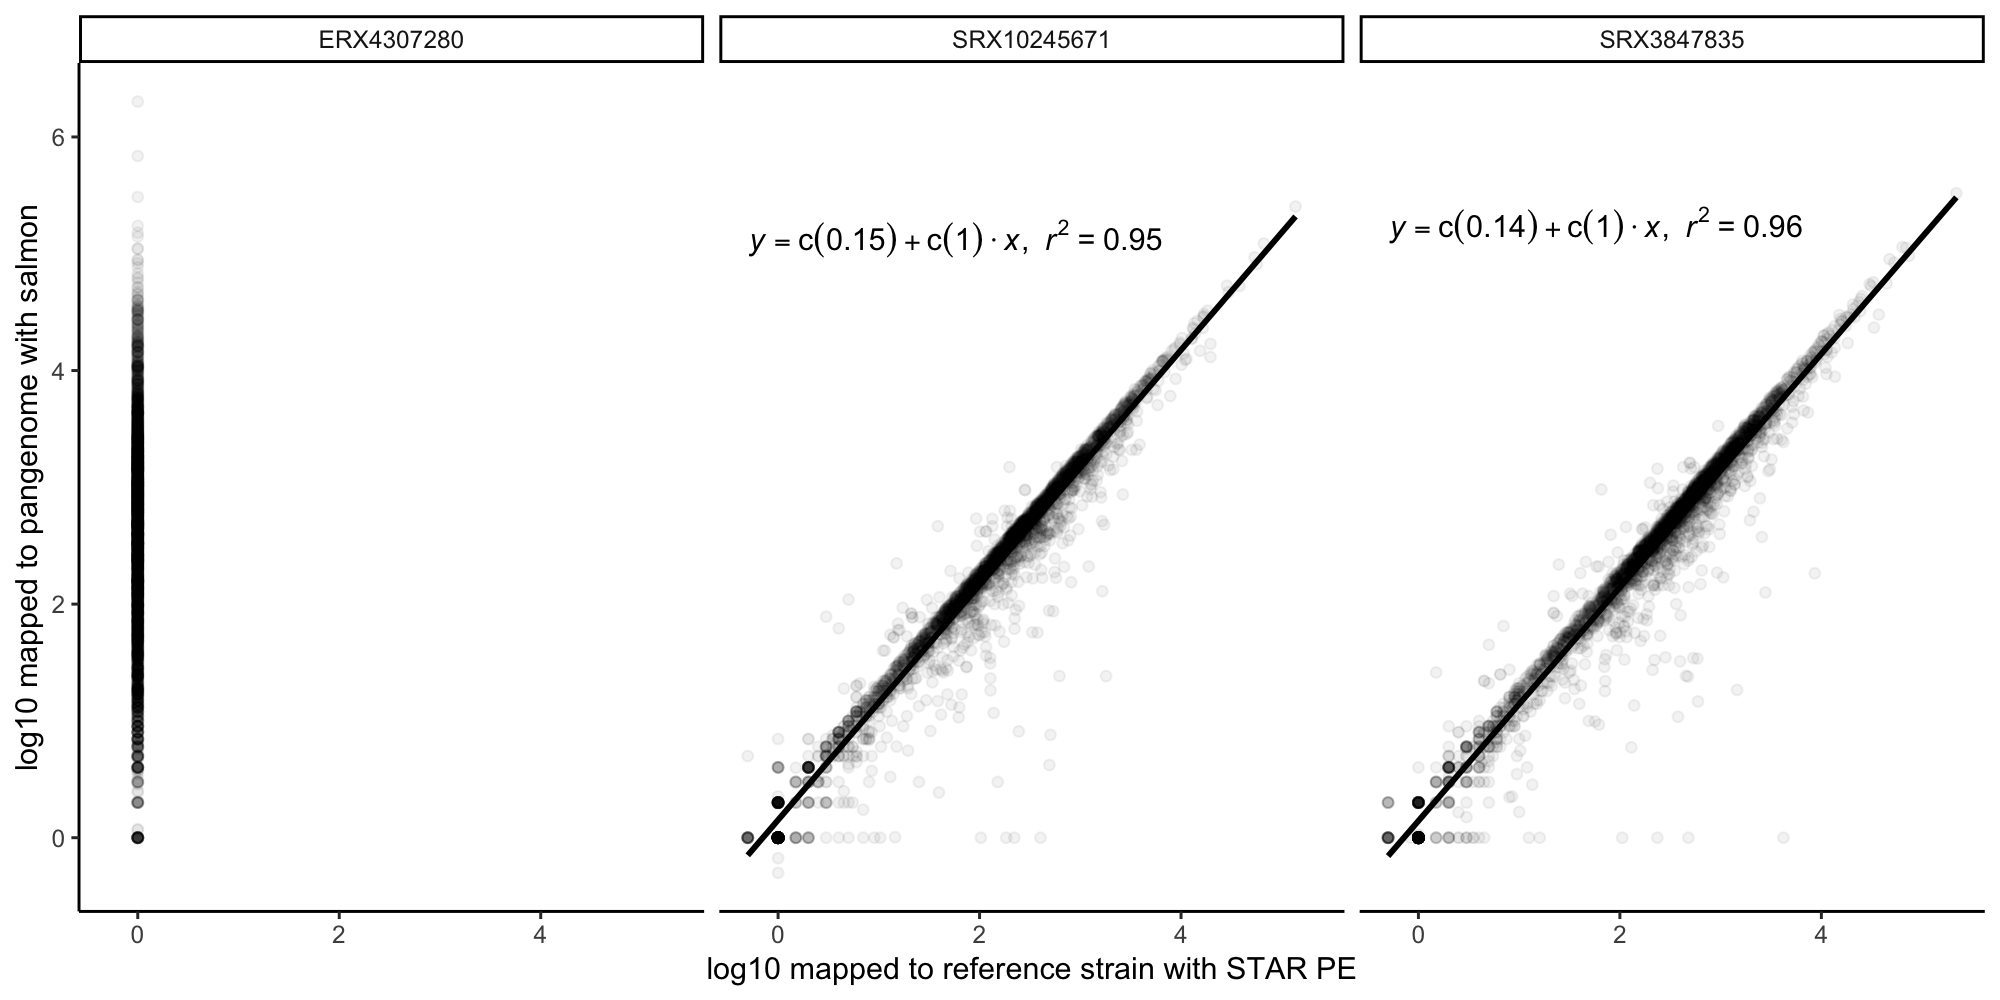

In [30]:
ggplot(counts2, aes(x = log10_gs_pe_ref_counts, y = log10_salmon_counts, label = sequence_name))  +
  geom_point(alpha = .05) +
  theme_classic() +
  labs(x = "log10 mapped to reference strain with STAR PE",
       y = "log10 mapped to pangenome with salmon") +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  facet_wrap(~sample)

## Conclusion

The pangenome pipeline looks like it does a pretty good job of capturing the same information. 
Potential future points to dig into in the future:
1. What are the genes/transcripts that have ~high counts measured with the gold standard pipeline but no/low counts measured with the pangenome pipeline (fall on the X axis)?
2. Did the pangenome approach inappropriately collapse paralogs? 
    - *Pseudomonas aeruginosa* may be a good genme to explore this in as Deb H. may have good incite into specific genes to look into.